In [4]:
#Preprocesss image


from PIL import Image
import numpy as np
import os

def preprocess_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for img_filename, mask_filename in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        try:
            # Load and preprocess image
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img = np.array(img, dtype=np.float32) / 255.0

            # Load and preprocess mask
            mask = Image.open(mask_path).convert('L')  # Grayscale
            mask = mask.resize(target_size)
            mask = np.array(mask, dtype=np.float32) / 255.0

            # Binarize the mask
            mask = (mask > 0.5).astype(np.float32)

            # Expand dims to make it (H, W, 1)
            mask = np.expand_dims(mask, axis=-1)

            # Append to lists
            images.append(img)
            masks.append(mask)

        except Exception as e:
            print(f" Failed to process {img_path} or {mask_path}: {e}")

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    print(f" Processed {len(images)} images and {len(masks)} masks")
    print(f"Image shape: {images.shape}")
    print(f"Mask shape: {masks.shape}")

    # Optional: Check unique mask values
    unique_values = np.unique(masks)
    print(f"Unique values in masks: {unique_values}")

    return images, masks


# Paths
image_dir = "/Users/anandhu/Downloads/Final Project/data/Image_data/Image"
mask_dir = "/Users/anandhu/Downloads/Final Project/data/Image_data/Mask"

# Preprocess
images, masks = preprocess_images_and_masks(image_dir, mask_dir)

✅ Processed 290 images and 290 masks
Image shape: (290, 256, 256, 3)
Mask shape: (290, 256, 256, 1)
Unique values in masks: [0. 1.]


In [5]:
print(images.shape)
print(masks.shape)

(290, 256, 256, 3)
(290, 256, 256, 1)


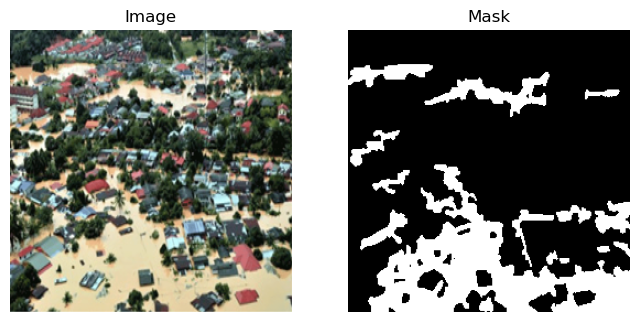

In [6]:
import matplotlib.pyplot as plt

def visualize_sample(images, masks, index=0):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(images[index])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[index].squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

visualize_sample(images, masks, index=0)



In [7]:
print(f"Image range: {images.min()} to {images.max()}")

Image range: 0.0 to 1.0


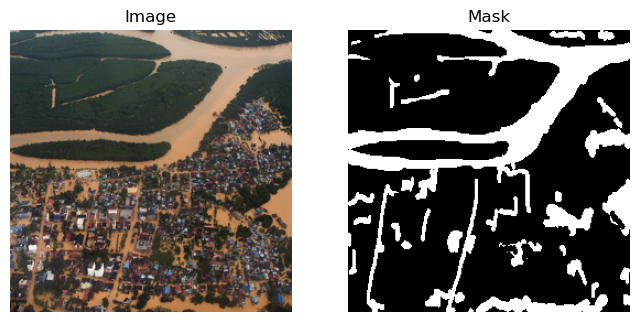

In [8]:
import random
index = random.randint(0, len(images) - 1)

def visualize_sample(images, masks, index):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(images[index])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[index].squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

visualize_sample(images, masks, index)

In [9]:
import os
import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


# ===========================================================
# 1. Data Augmentation & Generator
# ===========================================================

def augment_image_and_mask(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(p=0.2)
    ])

    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']


def data_generator(images, masks, batch_size=8, augment=False):
    while True:
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch_masks = masks[i:i + batch_size]

            if augment:
                augmented_images, augmented_masks = [], []
                for img, mask in zip(batch_images, batch_masks):
                    img, mask = augment_image_and_mask(img, mask)
                    augmented_images.append(img)
                    augmented_masks.append(mask)

                batch_images = np.array(augmented_images)
                batch_masks = np.array(augmented_masks)

            yield np.array(batch_images), np.array(batch_masks)


# ===========================================================
# 2. Custom U-Net Model Definition
# ===========================================================

def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder (Downsampling)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


# ===========================================================
# 3. IoU and Dice Metric Definitions
# ===========================================================

def iou_metric(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


def dice_metric(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)


# ===========================================================
# 4. Prepare Data Generators
# ===========================================================

# Assuming 80% train, 20% validation
train_images, val_images = images[:232], images[232:]
train_masks, val_masks = masks[:232], masks[232:]

batch_size = 8

train_gen = data_generator(train_images, train_masks, batch_size=batch_size, augment=True)
val_gen = data_generator(val_images, val_masks, batch_size=batch_size, augment=False)

steps_per_epoch = int(np.ceil(len(train_images) / batch_size))
validation_steps = int(np.ceil(len(val_images) / batch_size))

# ===========================================================
# 5. Build and Compile Custom U-Net
# ===========================================================

unet_model = build_unet(input_shape=(256, 256, 3))

unet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=sm.losses.bce_dice_loss,
    metrics=['accuracy', iou_metric, dice_metric]
)

# ===========================================================
# 6. Callbacks
# ===========================================================

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('unet_custom_best.h5', monitor='val_loss', save_best_only=True)

# ===========================================================
# 7. Train the Model
# ===========================================================

history = unet_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# ===========================================================
# 8. Evaluate the Model
# ===========================================================

loss, acc, iou, dice = unet_model.evaluate(val_gen, steps=validation_steps)
print(f"Validation Loss: {loss:.4f}, Accuracy: {acc:.4f}, IoU: {iou:.4f}, Dice: {dice:.4f}")

/opt/anaconda3/envs/COM726/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Segmentation Models: using `tf.keras` framework.
Epoch 1/50


/opt/anaconda3/envs/COM726/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


29/29 [==============================] - 20s 672ms/step - loss: 1.2512 - accuracy: 0.6048 - iou_metric: 0.3505 - dice_metric: 0.4888 - val_loss: 1.2714 - val_accuracy: 0.4599 - val_iou_metric: 0.3800 - val_dice_metric: 0.5466 - lr: 1.0000e-04
Epoch 2/50


/opt/anaconda3/envs/COM726/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 19s 654ms/step - loss: 1.2288 - accuracy: 0.5937 - iou_metric: 0.4659 - dice_metric: 0.6301 - val_loss: 1.2366 - val_accuracy: 0.5784 - val_iou_metric: 0.4381 - val_dice_metric: 0.6055 - lr: 1.0000e-04
Epoch 3/50
29/29 [==============================] - 19s 643ms/step - loss: 1.1523 - accuracy: 0.7051 - iou_metric: 0.4912 - dice_metric: 0.6531 - val_loss: 1.1056 - val_accuracy: 0.7091 - val_iou_metric: 0.5153 - val_dice_metric: 0.6756 - lr: 1.0000e-04
Epoch 4/50
29/29 [==============================] - 20s 674ms/step - loss: 1.0240 - accuracy: 0.7248 - iou_metric: 0.5124 - dice_metric: 0.6703 - val_loss: 0.9652 - val_accuracy: 0.7840 - val_iou_metric: 0.4592 - val_dice_metric: 0.6175 - lr: 1.0000e-04
Epoch 5/50
29/29 [==============================] - 19s 669ms/step - loss: 0.9813 - accuracy: 0.7351 - iou_metric: 0.5165 - dice_metric: 0.6727 - val_loss: 0.8939 - val_accuracy: 0.7958 - val_iou_metric: 0.5694 - val_dice_metric: 0.7194 - lr: 1.0000

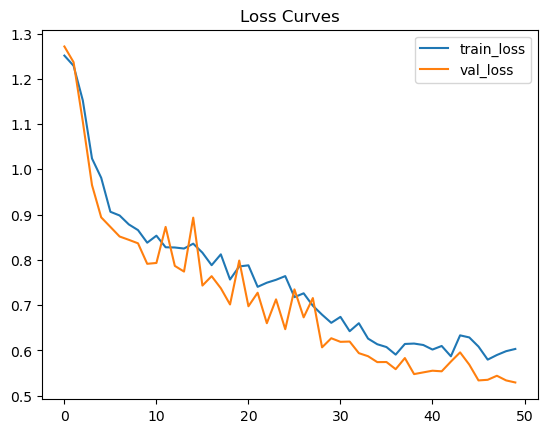

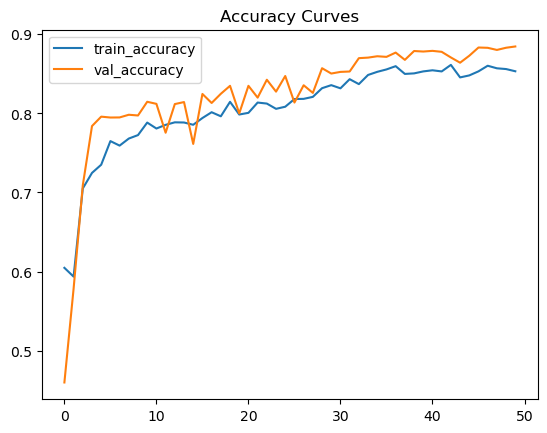

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

1/1 [==============================] - 0s 121ms/step


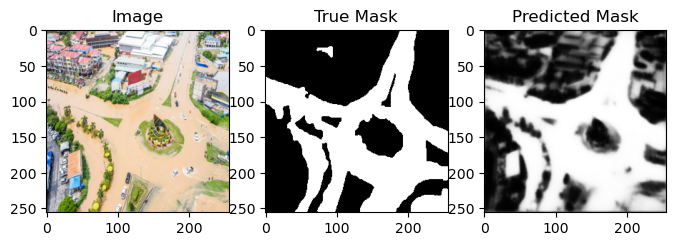

In [11]:
import matplotlib.pyplot as plt

sample_img = val_images[0]
sample_mask = val_masks[0]

pred_mask = unet_model.predict(np.expand_dims(sample_img, axis=0))[0]

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.show()

In [12]:
from tensorflow.keras.models import load_model

unet_model = load_model(
    'unet_custom_best.h5',
    custom_objects={
        'iou_metric': iou_metric,
        'dice_metric': dice_metric,
        'binary_crossentropy_plus_dice_loss': sm.losses.bce_dice_loss
    }
)

In [13]:
from tensorflow.keras.optimizers.legacy import Adam

unet_model.compile(
    optimizer=Adam(learning_rate=5e-6),  
    loss=sm.losses.bce_dice_loss,
    metrics=['accuracy', iou_metric, dice_metric]
)

In [14]:
fine_tune_history = unet_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  
)
unet_model.save('unet_finetuned_best.h5')

Epoch 1/10
29/29 [==============================] - 19s 625ms/step - loss: 0.5866 - accuracy: 0.8613 - iou_metric: 0.6829 - dice_metric: 0.8086 - val_loss: 0.5394 - val_accuracy: 0.8806 - val_iou_metric: 0.6978 - val_dice_metric: 0.8183 - lr: 5.0000e-06
Epoch 2/10
29/29 [==============================] - 18s 616ms/step - loss: 0.5863 - accuracy: 0.8596 - iou_metric: 0.6848 - dice_metric: 0.8101 - val_loss: 0.5297 - val_accuracy: 0.8837 - val_iou_metric: 0.6990 - val_dice_metric: 0.8191 - lr: 5.0000e-06
Epoch 3/10
29/29 [==============================] - 18s 620ms/step - loss: 0.5925 - accuracy: 0.8579 - iou_metric: 0.6823 - dice_metric: 0.8094 - val_loss: 0.5326 - val_accuracy: 0.8826 - val_iou_metric: 0.6981 - val_dice_metric: 0.8185 - lr: 5.0000e-06
Epoch 4/10
29/29 [==============================] - 18s 613ms/step - loss: 0.5825 - accuracy: 0.8603 - iou_metric: 0.6863 - dice_metric: 0.8119 - val_loss: 0.5326 - val_accuracy: 0.8826 - val_iou_metric: 0.6988 - val_dice_metric: 0.8190 -

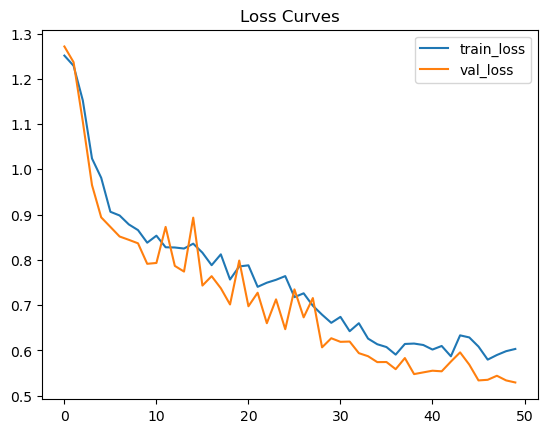

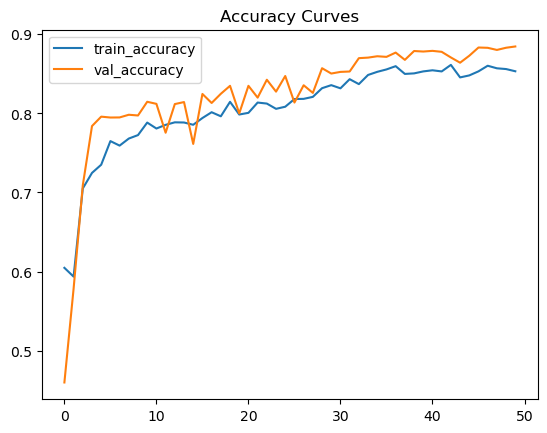

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

1/1 [==============================] - 0s 108ms/step


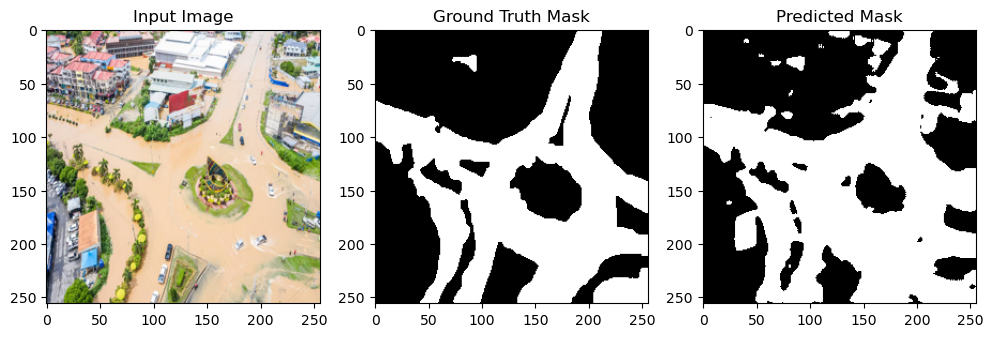

In [16]:
import matplotlib.pyplot as plt

# Take a sample image from validation or test set
sample_image = val_images[0] 
sample_mask = val_masks[0]

prediction = unet_model.predict(np.expand_dims(sample_image, axis=0))[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(sample_image)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask[:, :, 0], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[:, :, 0], cmap='gray')

plt.show()

1/1 [==============================] - 0s 36ms/step


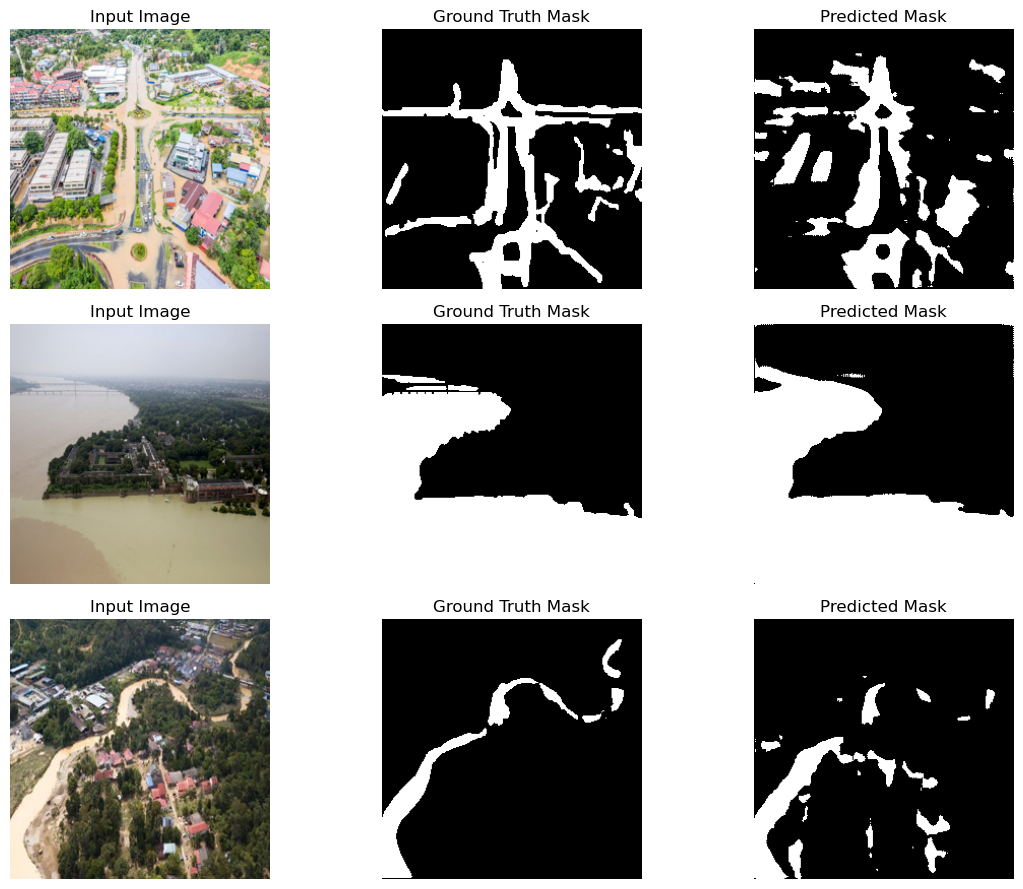

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, images, masks, num_samples=5):
    """
    Visualizes predictions of the model alongside ground truth masks.

    Args:
        model: Trained U-Net model.
        images: Numpy array of images (validation or test set).
        masks: Numpy array of corresponding ground truth masks.
        num_samples: Number of samples to visualize.
    """
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(12, num_samples * 3))
    for i, idx in enumerate(indices):
        img = images[idx]
        true_mask = masks[idx][:, :, 0]  # Remove channel dimension
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0][:, :, 0]

        # Convert prediction to binary mask
        pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

        # Plot original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_predictions(unet_model, val_images, val_masks, num_samples=3)